In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import h5py
try:
    import cupy as cp
    use_gpu = True
except:
    use_gpu = False
    
import pickle
import corner
import time

from stableemrifisher.fisher import StableEMRIFisher
from stableemrifisher.utils import inner_product, generate_PSD, padding

from few.utils.utility import get_p_at_t
from few.trajectory.inspiral import EMRIInspiral
from few.waveform import GenerateEMRIWaveform
from few.summation.aakwave import AAKSummation
from few.utils.constants import YRSID_SI
from few.utils.constants import SPEED_OF_LIGHT as C_SI

from fastlisaresponse import ResponseWrapper  # Response function 
from lisatools.detector import ESAOrbits #ESAOrbits correspond to esa-trailing-orbits.h5
from lisatools.sensitivity import get_sensitivity, A1TDISens, E1TDISens, T1TDISens

from scipy.integrate import quad, nquad
from scipy.interpolate import RegularGridInterpolator, CubicSpline
from scipy.stats import uniform
from scipy.special import factorial
from scipy.optimize import brentq, root

from scipy.stats import multivariate_normal
import warnings

from hierarchical.Hierarchical_Class import Hierarchical, Isource_vac, Isource_loc, Isource_glob, prior_vac, prior_loc, prior_glob, M_z_samples, A_n_samples
from hierarchical.JointWave import JointKerrWaveform, JointRelKerrEccFlux
from hierarchical.utility import getz

if not use_gpu:
    cfg_set = few.get_config_setter(reset=True)
    cfg_set.enable_backends("cpu")
    cfg_set.set_log_level("info")
else:
    pass #let the backend decide for itself.

startup


In [2]:
T_LISA = 1. #LISA observation duration
dt = 10.0 #sampling rate

max_step_days = 10.0 #maximum step size for inspiral calculation. Smaller number ensures a more accurate trajectory but higher computation time.

insp_kwargs = { "err": 1e-11, #Default: 1e-11 in FEW 2
                "max_step_size": max_step_days*24*60*60, #in seconds
                "buffer_length":int(1e6), 
               }

sum_kwargs = {
    "pad_output": True, # True if expecting waveforms smaller than LISA observation window.
}

Waveform_model = GenerateEMRIWaveform(
            JointKerrWaveform,
            inspiral_kwargs=insp_kwargs,
            sum_kwargs=sum_kwargs,
            use_gpu=use_gpu,
            return_list=False,
            frame="detector"
            )

#orbit_file_esa = "/home/shubham/FEW_KerrEcc/Github_Repos/lisa-on-gpu/orbit_files/esa-trailing-orbits.h5"
# orbit_file_esa = "/data/lsperi/lisa-on-gpu/orbit_files/equalarmlength-trailing-fit.h5"
#orbit_kwargs_esa = dict(orbit_file=orbit_file_esa)

tdi_gen ="1st generation"# "2nd generation"#

order = 20  # interpolation order (should not change the result too much)
tdi_kwargs_esa = dict(
    orbits=ESAOrbits(use_gpu=use_gpu), order=order, tdi=tdi_gen, tdi_chan="AE",
)  # could do "AET"

index_lambda = 8
index_beta = 7

# with longer signals we care less about this
t0 = 10000.0  # throw away on both ends when our orbital information is weird

EMRI_TDI = ResponseWrapper(
                        Waveform_model,
                        T_LISA,
                        t0=t0,
                        dt=dt,
                        index_lambda=index_lambda,
                        index_beta=index_beta,
                        flip_hx=True,  # set to True if waveform is h+ - ihx (FEW is)
                        use_gpu=use_gpu,
                        is_ecliptic_latitude=False,  # False if using polar angle (theta)
                        remove_garbage="zero",  # removes the beginning of the signal that has bad information
                        **tdi_kwargs_esa,
                        )

In [3]:
#hypothesis
hypothesis = 'global' #'vacuum', 'local', 'global'

#fixed parameters
T_LISA = 1.0 #observation time, years
dt = 10.0 #sampling interval, seconds

m1 = 1e6 #MBH mass in solar masses (source frame)
m2 = 10.0 #secondary mass in solar masses (source frame)
a = 0.9 #dimensionless spin of the primary
e0 = 0.0 #eccentricity of the CO orbit
x0 = 1.0 #inclination, must be = 1.0 for equatorial model

# initial phases
Phi_phi0 = 0.0 #azimuthal phase
Phi_theta0 = 0.0 #polar phase
Phi_r0 = 0.0 #radial phase

# define the extrinsic parameters
qK = np.pi / 3  # polar spin angle
phiK = np.pi / 4  # azimuthal viewing angle
qS = np.pi / 5  # polar sky angle
phiS = np.pi / 6  # azimuthal viewing angle
dist = 1.0  # distance in Gpc. We'll adjust this later to fix the SNR as 100.0

#BVGR params
if hypothesis == 'vacuum':
    f = 0.0
    Al = 0.0
    nl = 8.0
    Ag = 0.0
    ng = 4.0
    mu_l = [Al,nl]
    
elif hypothesis == 'local':
    f = 0.5
    Al = 0.8e-5
    nl = 7.5
    Ag = 0.0
    ng = 4.0
    mu_l = [Al,nl]
    
if hypothesis == 'global':
    f = 0.0
    Al = 0.0
    nl = 8.0
    Ag = 0.9e-9
    ng = 4.0
    mu_l = [Al,nl]
    
K = 5e-3
alpha = 0.2
beta = 0.2
Mstar = 3e6

vec_l = [Al, nl]

print(np.array(vec_l) - np.array(mu_l))
sigma_l = [1e-6,1.0]

Gdot = Ag

Omega_m0 = 0.30
Omega_Lambda0 = 0.70
H0 = 70e6 #m/s/Gpc

z = getz(dist, H0 = H0, Omega_Lambda0=Omega_Lambda0, Omega_m0=Omega_m0)
print(z)
traj_joint = EMRIInspiral(func=JointRelKerrEccFlux)
p0 = get_p_at_t(traj_joint,
                  T_LISA,
                  [m1,
                   m2,
                   a,
                   e0, #e0
                   x0, #Y0
                   Al,
                   nl,
                   Ag,
                   ng, #ng
                  ],
                  ) + 0.5 #buffer

print(p0)

[0. 0.]
0.2036357400140082
7.664346725413963


In [4]:
#calculate the Fisher matrix
filename = f'validation_{hypothesis}'
if not os.path.exists(filename):
    os.mkdir(filename)
    
if hypothesis == 'vacuum':
    param_names = ['m1','dist'] #parameter to vary in FIM calculation
elif hypothesis == 'local':
    param_names = ['m1','dist','Al','nl'] #parameter to vary in FIM calculation
elif hypothesis == 'global':
    param_names = ['m1','dist','Ag'] #parameter to vary in FIM calculation
    
try:
    with h5py.File(f"{filename}/Fisher.h5") as ff:
        Fisher = ff["Fisher"][:]
except:   

    #noise model setup
    channels = [A1TDISens, E1TDISens]
    noise_kwargs = [{"sens_fn": channel_i} for channel_i in channels]

    #delta_range for additional parameters (because the default ranges may not be suitable)
    Ndelta = 12
    delta_range = {
    "Al":np.geomspace(1e-5,1e-10,Ndelta),
    "nl":np.geomspace(1.0,1e-5,Ndelta),
    "Ag":np.geomspace(1e-8,1e-14,Ndelta),
    }

    sef_kwargs = {
            'EMRI_waveform_gen':EMRI_TDI, #EMRI waveform model with TDI response
            'param_names': param_names, #params to be varied. m1 is alias for MBH mass in latest version of SEF. !!! DO NOT CHANGE THIS ORDER !!!
            'der_order':4, #derivative order
            'Ndelta':Ndelta, #number of stable points
            'delta_range':delta_range,#custom delta range for additional parameters
            'stats_for_nerds': False, #true if you wanna print debugging info
            'stability_plot': False, #true if you wanna plot stability surfaces
            'use_gpu':use_gpu,
            'plunge_check':False, #no need to check for plunge --- away from plunge already ensured.
            'noise_model': get_sensitivity,
            'channels':channels,
            'noise_kwargs':noise_kwargs,
            'filename':filename,
    }

    param_list = [m1, m2, a, p0, e0, x0, dist, qS, phiS, qK, phiK, Phi_phi0, Phi_theta0, Phi_r0]
    add_param_args = {"Al":Al, "nl":nl, "Ag":Ag, "ng":ng} #dict of additional parameters
    emri_kwargs = {'T': T_LISA, 'dt': dt}

    sef = StableEMRIFisher(*param_list, **emri_kwargs, **sef_kwargs, add_param_args=add_param_args)
    Fisher = sef()

In [5]:
#transform the Fisher from M, dist, to lnM, z

def Jacobian(M,dist,H0,Omega_m0,Omega_Lambda0):
    """ 
    Jacobian for Fisher parameter transformation from [M,dist,Al,nl,Ag] to [M,z,Al,nl,Ag]
    Returns a 5x5 diagonal np.ndarray.
    """
    
    #Jacobian = partial old/partial new
    
    delta = dist*1e-5
    del_z_del_dist = ((getz(dist+delta,H0,Omega_m0,Omega_Lambda0)-getz(dist-delta,H0,Omega_m0,Omega_Lambda0))/(2*delta))
    diag = np.diag((1.0,(del_z_del_dist)**-1,1.0,1.0,1.0))
    
    return diag

J = Jacobian(m1, dist, H0, Omega_m0, Omega_Lambda0)[:len(Fisher),:len(Fisher)]
Fisher_transformed = J.T @ Fisher @ J 

try:
    with h5py.File(f"{filename}/Fisher.h5", "a") as ff:
        ff.create_dataset("Fisher_transformed", data = Fisher_transformed)
except ValueError:
    pass

In [39]:
Fisher_transformed

array([[ 7.02026218e+03,  9.94341210e-02, -2.44906933e+10,
         6.12889051e+04],
       [ 9.94341210e-02,  4.62704118e+05, -6.98413056e+05,
         1.80423012e+00],
       [-2.44906933e+10, -6.98413056e+05,  8.68124720e+16,
        -2.17752869e+11],
       [ 6.12889051e+04,  1.80423012e+00, -2.17752869e+11,
         5.46381797e+05]])

(<Figure size 2000x2000 with 10 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='dist'>, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: ylabel='Al'>, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: xlabel='m1', ylabel='nl'>, <Axes: xlabel='dist'>,
         <Axes: xlabel='Al'>, <Axes: xlabel='nl'>]], dtype=object))

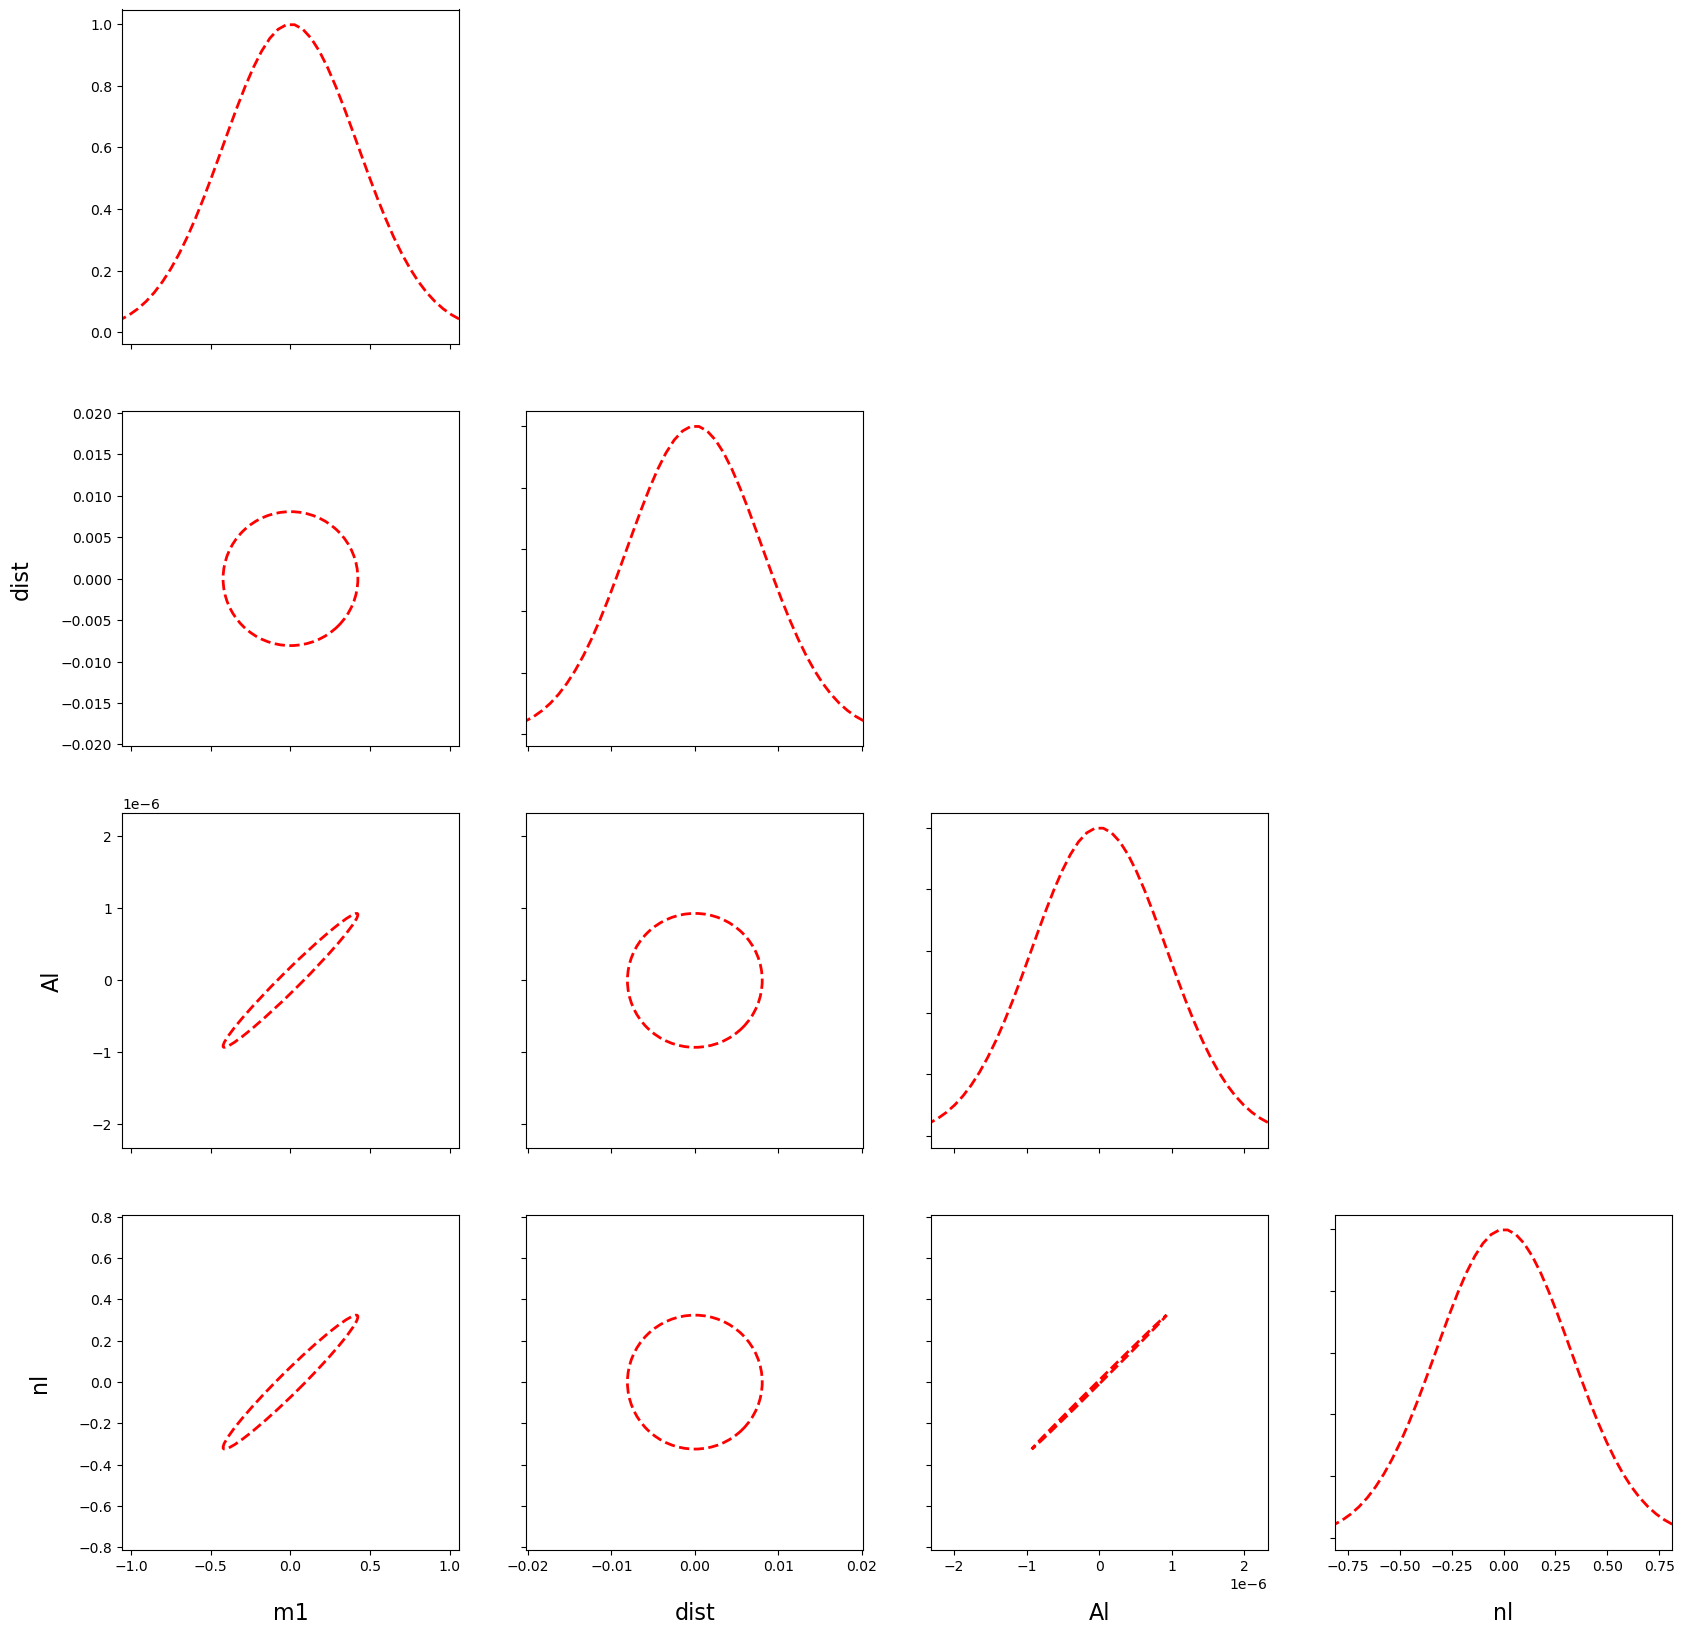

In [58]:
from stableemrifisher.plot import CovEllipsePlot

CovEllipsePlot(np.linalg.inv(Fisher),color='r',linestyle='--', param_names=param_names)

In [7]:
#calculate the approximate integral

with h5py.File(f"{filename}/Fisher.h5", "r") as ff:
    Fisher_transformed = ff["Fisher_transformed"][:]

print(f)

if hypothesis == 'vacuum':
    approx_integral = Isource_vac(m1, z, K, alpha, beta, Fisher_transformed, H0, Omega_m0, Omega_Lambda0, Mstar = Mstar)
elif hypothesis == 'local':
    approx_integral = Isource_loc(m1, z, vec_l, K, alpha, beta, f, mu_l, sigma_l, Fisher_transformed, H0, Omega_m0, Omega_Lambda0, Mstar = Mstar)
elif hypothesis == 'global':
    approx_integral = Isource_glob(m1, z, Ag, K, alpha, beta, Gdot, Fisher_transformed, H0, Omega_m0, Omega_Lambda0, Mstar=Mstar)

from hierarchical.Hierarchical_Class import lnIsource_glob

if hypothesis == 'global':
    approx_integral_log = np.exp(lnIsource_glob(m1, z, Ag, K, alpha, beta, Gdot, Fisher_transformed, H0, Omega_m0, Omega_Lambda0, Mstar=Mstar))

print(approx_integral, approx_integral_log)

0.0
19173594765.738724 19173594765.73869


In [7]:
#calculate the exact integral with a numerical approximation

def likelihood(Fisher, theta, theta_hat):
    #return det(Fisher)^(1/2)/(2pi)^(d/2) exp(-1/2 * (theta - theta_hat) dot Fisher dot (theta - theta_hat))
    #Fisher [lnM, z, Al, nl, Ag] or subset thereof
    
    delta = theta - theta_hat
    dim = len(Fisher)
    
    assert len(theta) == len(theta_hat)
    assert len(theta) == dim
    
    expterm = np.dot(np.dot(delta, Fisher), delta)
    
    like = np.exp(-0.5 * expterm) * np.linalg.det(Fisher)**0.5 / ((2 * np.pi) ** (dim/2))
    
    #print('delta: ', delta, 'expterm: ', expterm)
    
    return like

def like_times_prior(Fisher, theta, theta_hat, hypothesis, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar, f = None, mu_l = None, sigma_l = None, Gdot = None):
    
    like = likelihood(Fisher, theta, theta_hat)
    
    #print('theta: ', theta)
    
    if hypothesis == 'vacuum':
        m1, z = theta
        #m1 = np.exp(lnm1)
        
        prior = prior_vac(m1, z, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar)
        
    elif hypothesis == 'local':
        
        m1, z, Al, nl = theta
    
        if (Al == 0.0) and (nl == 0.0):
            prior = prior_vac(m1, z, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar) * (1 - f)
        
        else:
            
            vec_l = [Al, nl]
            #m1 = np.exp(lnm1)

            vec_l = np.array(vec_l)
            mu_l = np.array(mu_l)
            sigma_l = np.array(sigma_l)

            Gamma_l = np.diag(1/sigma_l**2)

            #print(f, np.linalg.det(Gamma_l)**(1/2)/(2*np.pi), vec_l-mu_l, Gamma_l)

            prior = prior_vac(m1, z, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar) * prior_loc(vec_l, f, mu_l, sigma_l)
    
    elif hypothesis == 'global':
        m1, z, Ag = theta
        #m1 = np.exp(lnm1)

        prior = prior_vac(m1, z, K, alpha, beta, H0, Omega_m0,Omega_Lambda0, Mstar) #* prior_glob(Ag, Gdot)
    
    #print(like, prior)
    return like * prior

In [8]:
#monte carlo integral

Ngridsize = 11
Nrange = [int(1e4),int(5e6)]
Ngrid = np.geomspace(Nrange[0],Nrange[1],Ngridsize).astype(int)

with h5py.File(f"{filename}/Fisher.h5", "r") as ff:
    Fisher_transformed = ff["Fisher_transformed"][:] #m1, z
    
Fisher_inverse = np.linalg.inv(Fisher_transformed)
std_m1 = np.sqrt(Fisher_inverse[0,0])
std_z = np.sqrt(Fisher_inverse[1,1])

bounds_vacuum = [
    [(m1) - 3 * std_m1, (m1) + 3 * std_m1], #bounds on m1
    [z - 3 * std_z, z + 3 * std_z] #bounds on z
]

if hypothesis == 'local':
    
    std_Al = np.sqrt(Fisher_inverse[2,2])
    std_nl = np.sqrt(Fisher_inverse[3,3])
    
    bounds_local = bounds_vacuum + [
        [Al - 3 * std_Al, Al + 3 * std_Al], #bounds on Al
        [nl - 3 * std_nl, nl + 3 * std_nl] #bounds on nl
    ]

if hypothesis == 'global':
    
    std_Ag = np.sqrt(Fisher_inverse[2,2])
    
    bounds_global = bounds_vacuum + [
        [Ag - 3 * std_Ag, Ag + 3 * std_Ag]
    ]

integral_all = []

for N in tqdm(Ngrid):
    
    integral_exact = 0.0
    
    if hypothesis == 'vacuum':
        
        samples = np.random.uniform(
                                low=[bounds_vacuum[0][0], bounds_vacuum[1][0]],
                                high=[bounds_vacuum[0][1], bounds_vacuum[1][1]],
                                size=(N, 2)
                            )
        
        M_samples = samples[:,0]
        z_samples = samples[:,1]
        
        prior_volume = np.prod(np.array(bounds_vacuum)[:,1] - np.array(bounds_vacuum)[:,0])
    
    elif hypothesis == 'local':
        
        samples = np.random.uniform(
                                low=[bounds_local[0][0], bounds_local[1][0], bounds_local[2][0], bounds_local[3][0]],
                                high=[bounds_local[0][1], bounds_local[1][1], bounds_local[2][1], bounds_local[3][1]],
                                size=(N, 4)
                            )
        
        M_samples = samples[:,0]
        z_samples = samples[:,1]
        Al_samples = samples[:,2]
        nl_samples = samples[:,3]
        
        prior_volume = np.prod(np.array(bounds_local)[:,1] - np.array(bounds_local)[:,0])
        
    elif hypothesis == 'global':
        
        samples = np.random.uniform(
                                low=[bounds_vacuum[0][0], bounds_vacuum[1][0]],
                                high=[bounds_vacuum[0][1], bounds_vacuum[1][1]],
                                size=(N, 2)
                            )
        
        M_samples = samples[:,0]
        z_samples = samples[:,1]
        
        Ag_samples = np.ones(N) * Gdot #integral evaluated at a fixed Ag = Gdot.
            
        prior_volume = np.prod(np.array(bounds_vacuum)[:,1] - np.array(bounds_vacuum)[:,0]) #np.prod(np.array(bounds_global)[:,1] - np.array(bounds_global)[:,0])
        
    for i in range(N):
        
        if hypothesis == 'vacuum':
            
            theta = np.array([M_samples[i], z_samples[i]])
            theta_hat = np.array([m1, z])
            
            integral_exact += like_times_prior(Fisher_transformed, theta, theta_hat, hypothesis, K, alpha, beta, H0, Omega_m0, Omega_Lambda0, Mstar)
            
        elif hypothesis == 'local':
            
            theta = np.array([M_samples[i], z_samples[i], Al_samples[i], nl_samples[i]])
            theta_hat = np.array([m1, z, Al, nl])
            
            integral_exact += like_times_prior(Fisher_transformed, theta, theta_hat, hypothesis, K, alpha, beta, H0, Omega_m0, Omega_Lambda0, Mstar, f, mu_l, sigma_l)

        elif hypothesis == 'global':
            
            theta = np.array([M_samples[i], z_samples[i], Ag_samples[i]])
            theta_hat = np.array([m1, z, Ag])
            
            integral_exact += like_times_prior(Fisher_transformed, theta, theta_hat, hypothesis, K, alpha, beta, H0, Omega_m0, Omega_Lambda0, Mstar, Gdot=Gdot)
    
    integral_all.append(integral_exact * prior_volume / N)

100%|███████████████████████████████████████████| 11/11 [12:10<00:00, 66.38s/it]


In [11]:
np.savetxt(f'{filename}/integral_all.txt',np.array(integral_all)/approx_integral)

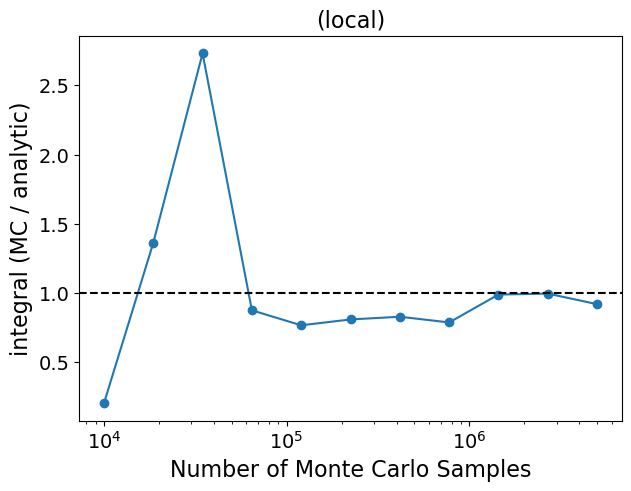

In [10]:
plt.figure(figsize=(7,5))
plt.semilogx(Ngrid, np.array(integral_all)/approx_integral,'o-')
plt.axhline(1.0,color='black',linestyle='--')
plt.xlabel('Number of Monte Carlo Samples',fontsize=16)
plt.ylabel(r'integral (MC / analytic)',fontsize=16)
plt.tick_params(axis='both', labelsize=14)
plt.title(f'({hypothesis})',fontsize=16)
plt.savefig(f'{filename}/integral_validation_{hypothesis}.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
def integrand_vacuum(m1, z, Fisher, theta_hat, hypothesis, K, alpha, beta, H0, Omega_m0, Omega_Lambda0, Mstar):
    theta = np.array([m1, z])
    return like_times_prior(Fisher, theta, theta_hat, hypothesis, K, alpha, beta, H0, Omega_m0, Omega_Lambda0, Mstar)

def integrand_local(m1, z, Al, nl, Fisher, theta_hat, hypothesis, K, alpha, beta, H0, Omega_m0, Omega_Lambda0, Mstar, f, mu_l, sigma_l):
    theta = np.array([m1, z, Al, nl])
    return like_times_prior(Fisher, theta, theta_hat, hypothesis, K, alpha, beta, H0, Omega_m0, Omega_Lambda0, Mstar, f, mu_l, sigma_l)

def integrand_global(m1, z, Ag, Fisher, theta_hat, hypothesis, K, alpha, beta, H0, Omega_m0, Omega_Lambda0, Mstar, Gdot):
    theta = np.array([m1, z, Ag])
    return like_times_prior(Fisher, theta, theta_hat, hypothesis, K, alpha, beta, H0, Omega_m0, Omega_Lambda0, Mstar, Gdot=Gdot)


with h5py.File(f"{filename}/Fisher.h5", "r") as ff:
    Fisher_transformed = ff["Fisher_transformed"][:] #m1, z
    
Fisher_inverse = np.linalg.inv(Fisher_transformed)
print(np.sqrt(np.diag(Fisher_inverse)))
std_m1 = np.sqrt(Fisher_inverse[0,0])
std_z = np.sqrt(Fisher_inverse[1,1])

bounds_vacuum = [
    [(m1) - 3 * std_m1, (m1) + 3 * std_m1], #bounds on m1
    [z - 3 * std_z, z + 3 * std_z] #bounds on z
]

if hypothesis == 'local':
    
    std_Al = np.sqrt(Fisher_inverse[2,2])
    std_nl = np.sqrt(Fisher_inverse[3,3])
    
    bounds_local = bounds_vacuum + [
        [Al - 3 * std_Al, Al + 3 * std_Al], #bounds on Al
        [nl - 3 * std_nl, nl + 3 * std_nl] #bounds on nl
    ]

if hypothesis == 'global':
    
    std_Ag = np.sqrt(Fisher_inverse[2,2])
    
    bounds_global = bounds_vacuum + [
        [Ag - 3 * std_Ag, Ag + 3 * std_Ag]
    ]


if hypothesis == 'vacuum':
            
    theta_hat = np.array([(m1), z])
    result, error = nquad(
    integrand_vacuum,
    bounds_vacuum,
    args=(Fisher_transformed, theta_hat, hypothesis, K, alpha, beta, H0, Omega_m0, Omega_Lambda0, Mstar),
    opts=[{"epsrel":1e-2, "epsabs":1e-2} for _ in range(len(theta_hat))]
)
    
elif hypothesis == 'local':
            
    theta_hat = np.array([(m1), z, Al, nl])
    result, error = nquad(
    integrand_local,
    bounds_local,
    args=(Fisher_transformed, theta_hat, "local", K, alpha, beta, H0, Omega_m0, Omega_Lambda0, Mstar, f, mu_l, sigma_l),
    opts=[{"epsrel":1e-2, "epsabs":1e-2} for _ in range(len(theta_hat))]
)
    
elif hypothesis == 'global':

    theta_hat = np.array([(m1), z, Ag])
    result, error = nquad(
    integrand_global,
    bounds_global,
    args=(Fisher_transformed, theta_hat, "global", K, alpha, beta, H0, Omega_m0, Omega_Lambda0, Mstar, Gdot),
    opts=[{"epsrel":1e-2, "epsabs":1e-2} for _ in range(len(theta_hat))]
)
       
print("nquad of exact: ", result, '+-', error)
print("analytic approx: ", approx_integral)
print("ratio: ", result/approx_integral)